In [1]:
%matplotlib inline
import sys
BIN = '../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')


In [2]:
from nn_utils import AE_big, AE_3D_200
from utils import plot_activations

In [3]:
torch.cuda.is_available()

False

In [4]:
#fastai.torch_core.defaults.device = 'cuda'

In [5]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/TLA_4D_leading_jets_train.pkl')
test = pd.read_pickle(BIN + 'processed_data/TLA_4D_leading_jets_test.pkl')
n_features = len(train.loc[0])

train = train.sample(frac=0.2)
test = test.sample(frac=1)

train.head(10)

,m,pt,phi,eta
369333,15396.075195,99910.914062,-0.774674,0.452453
1057469,10398.451172,138299.796875,2.679384,1.308938
1465373,12738.285156,122573.867188,1.283661,1.094443
1744887,8951.170898,99534.531250,0.224615,0.178013
1237968,7798.018555,115506.765625,-1.812271,-2.528340
2197969,14981.720703,127973.921875,2.840271,0.795834
2223672,15365.636719,91789.898438,-0.586960,-0.503187
435353,7040.160156,93421.500000,-2.969664,-0.265714
1200767,5584.588379,114501.335938,-1.956968,0.019311
635371,16502.005859,144506.109375,-0.572738,-1.223042


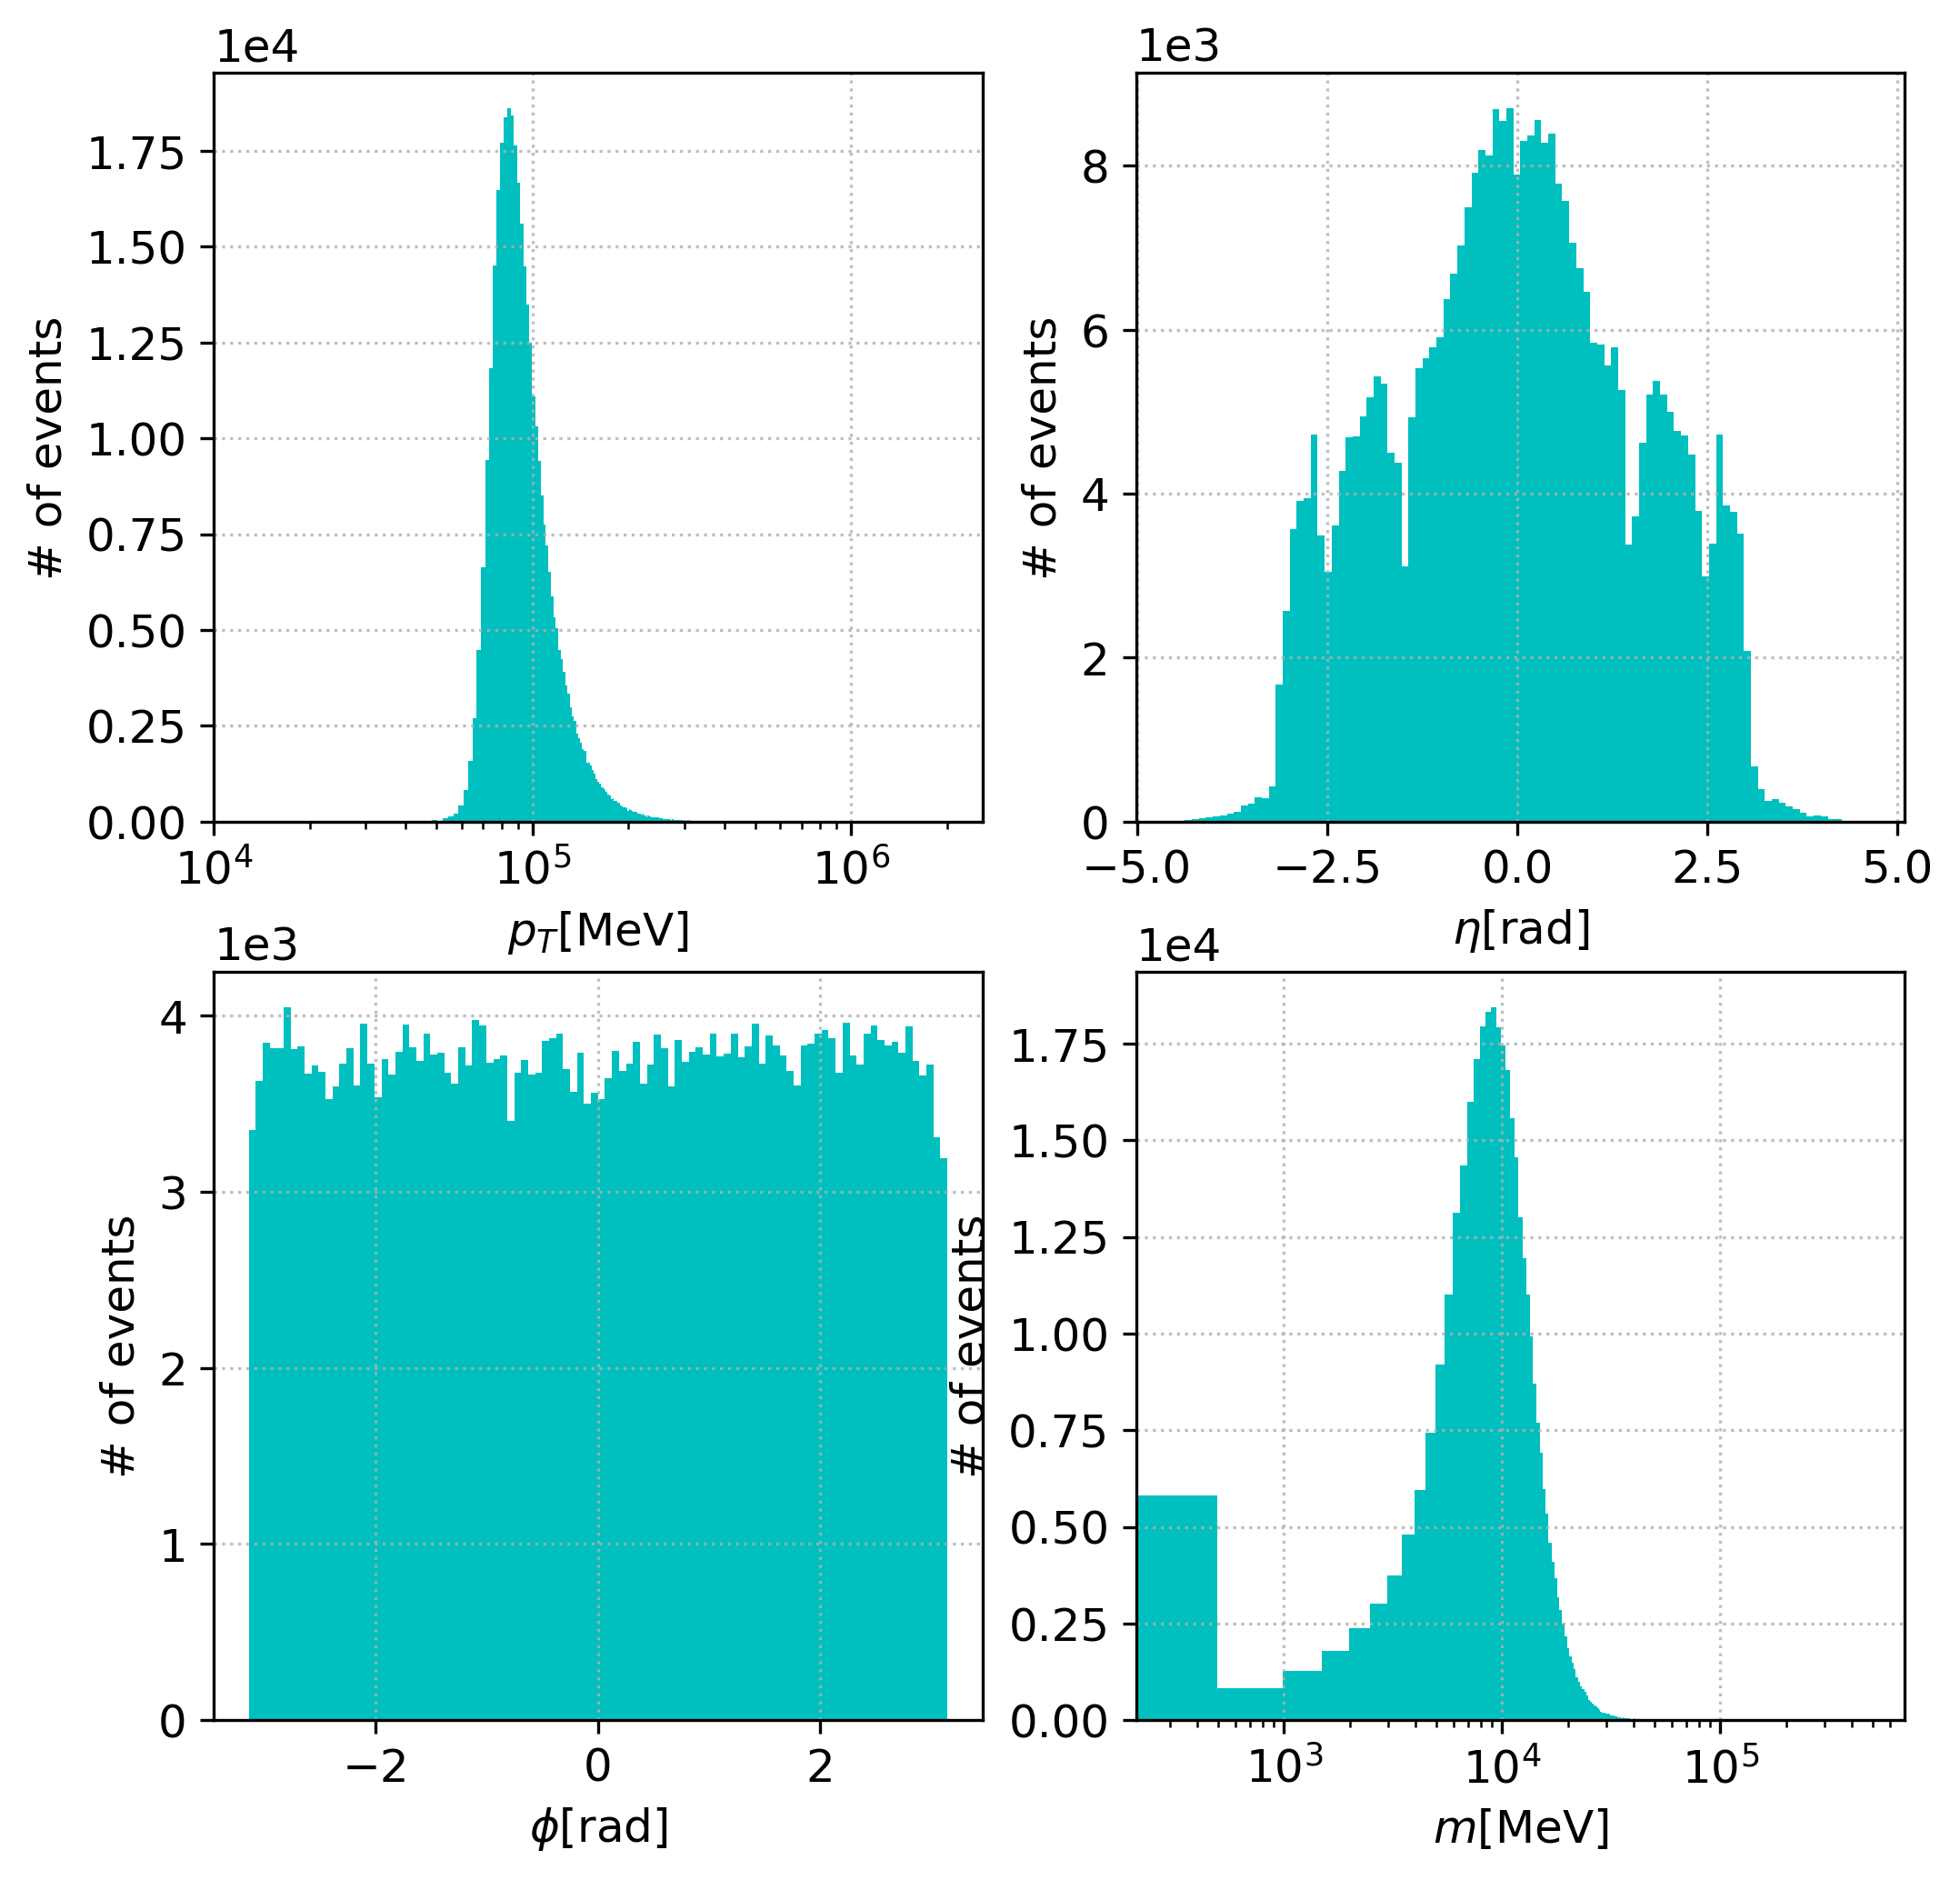

In [6]:
plt.close('all')
unit_list = ['[MeV]', '[rad]', '[rad]', '[MeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$m$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

import matplotlib

branches=["pt","eta","phi","m"]

%matplotlib inline
n_bins = 100
alph = 0.8
#for kk in np.arange(4):
#plt.rc('font', size=1)


fig, axs = plt.subplots(2,2,figsize=(8,8))
fig.set(dpi=300)

plt.rcParams.update({'font.size': 12})

for kk,ax in enumerate([axs[0][0],axs[0][1],axs[1][0],axs[1][1]]):
    #plt.figure(kk + 4)
    #plt.figure(figsize=(6,6))
    n_bins = 100
    if kk in [0,3]:
        n_bins = 1000
    ax.xaxis.get_offset_text().set_fontsize(12)
    ax.yaxis.get_offset_text().set_fontsize(12)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    n_hist_data, bin_edges, _ = ax.hist(train[branches[kk]], color=colors[1], label='Input', alpha=1, bins=n_bins)
    #n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    #plt.suptitle(branches[kk])
    ax.set_xlabel(xlabel=variable_list[kk] + unit_list[kk],fontsize=12)
    ax.set_ylabel('# of events', fontsize=12)
    ms.sciy()
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    if kk in [0,3]:
        ax.set_xscale('log')
    #ax.xlim(0,0.25e5)
    if kk == 0:
        ax.set_xlim(left=1e4)
    if kk == 3:
        ax.set_xlim(left=2.1e2)
    #ax.tight_layout()
    # plt.yscale('log')
    #plt.legend(loc=4)
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    #plt.savefig("TLA_fourmomenta",dpi=300)

In [7]:
# Normalize
#train_mean = train.mean()
#train_std = train.std()

#train = (train - train_mean) / train_std
#test = (test - train_mean) / train_std

eta_div = 5
phi_div = 3
m_div = 1.8
m_add = 1
pt_div = 1.2
pt_sub = 1.3

train = train.loc[train["m"] > 0.08]
test = test.loc[test["m"] > 0.08]

for data in [train,test]:
    data['eta'] = data['eta'] / eta_div
    data['phi'] = data['phi'] / phi_div
    data['m'] = np.log10(data['m'] + m_add) / m_div - 2
    data['pt'] = (np.log10(data['pt']) - pt_sub) / pt_div - 3

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

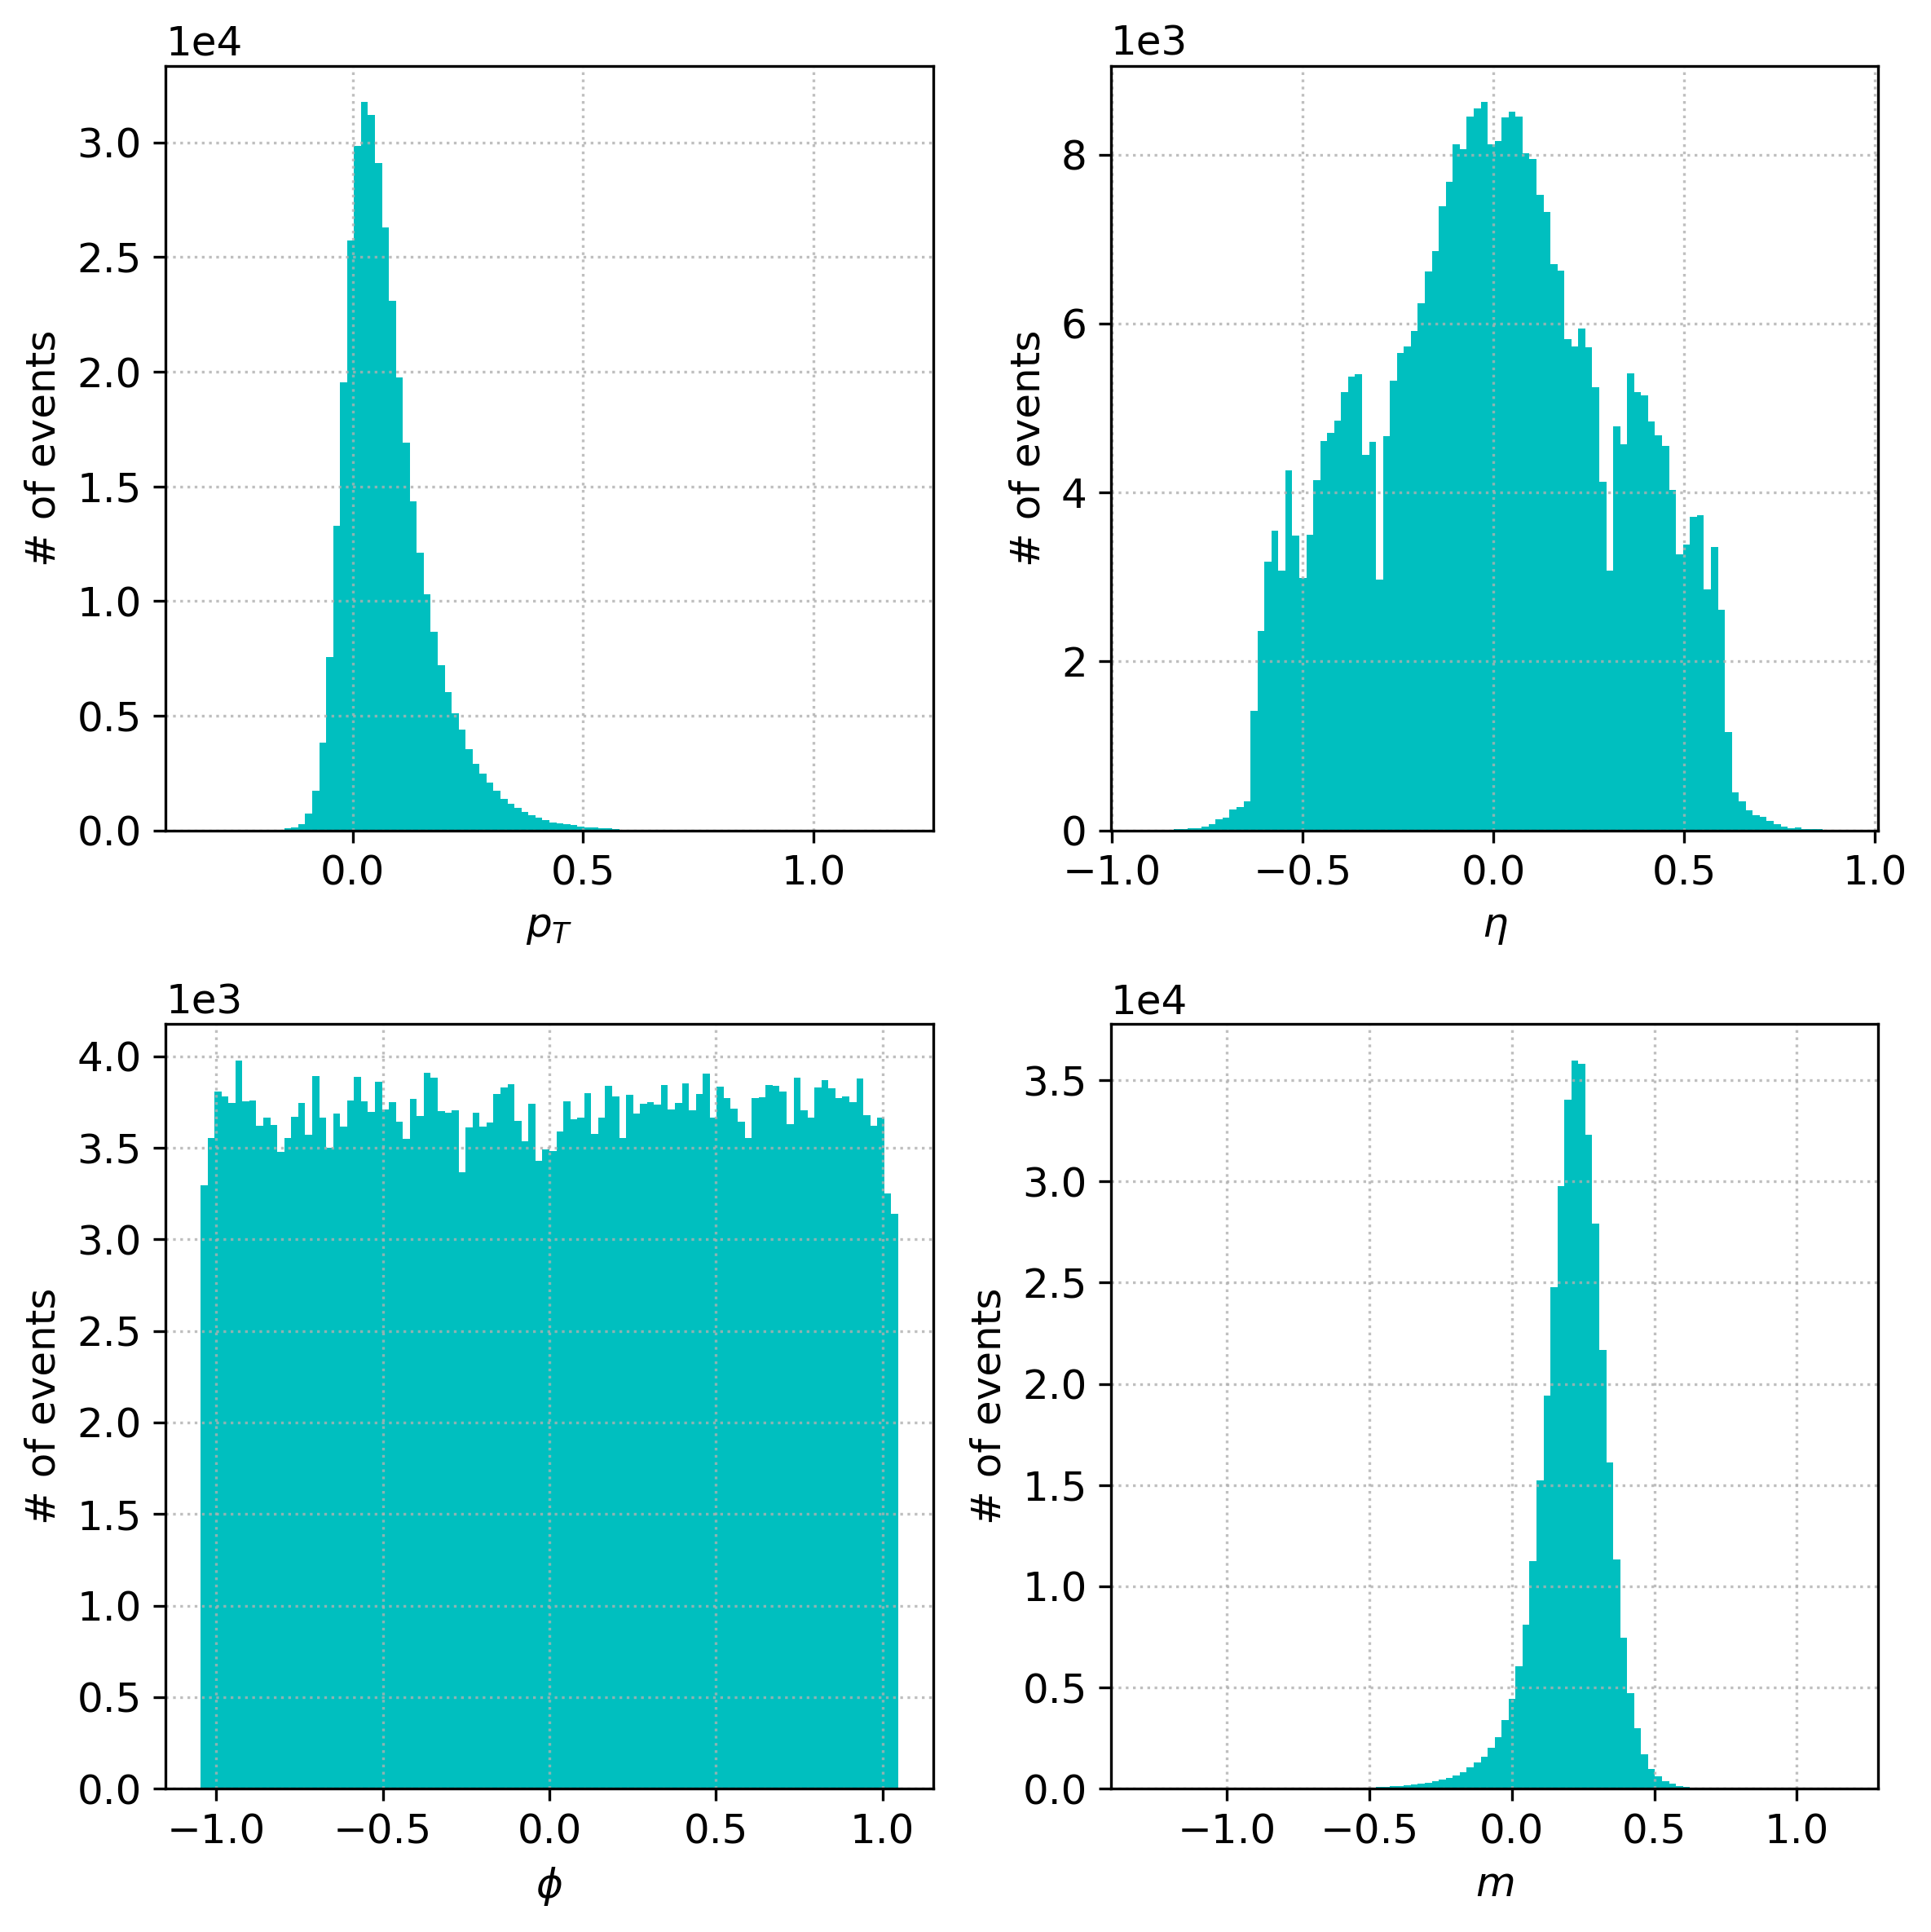

In [8]:
plt.close('all')
unit_list = ['[MeV]', '[rad]', '[rad]', '[MeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$m$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

branches=["pt","eta","phi","m"]

%matplotlib inline
n_bins = 100
alph = 0.8

fig, axs = plt.subplots(2,2,figsize=(8,8))
fig.set(dpi=300)

#for kk in np.arange(4):
for kk,ax in enumerate([axs[0][0],axs[0][1],axs[1][0],axs[1][1]]):
    #plt.figure(kk + 4)
    #plt.figure(figsize=(6,6))
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.xaxis.get_offset_text().set_fontsize(12)
    ax.yaxis.get_offset_text().set_fontsize(12)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    n_hist_data, bin_edges, _ = ax.hist(train[branches[kk]], color=colors[1], label='Input', alpha=1, bins=n_bins)
    #n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    #plt.suptitle(branches[kk])
    ax.set_xlabel(variable_list[kk], fontsize=12)
    ax.set_ylabel('# of events', fontsize=12)
    ms.sciy()
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    #plt.xlim(-5, 10)
    # plt.yscale('log')
    #plt.legend(loc=4)
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    plt.tight_layout()
    #plt.savefig("TLA_4D_normalized")

In [9]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [10]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

In [11]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [12]:
db

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f7cd74d5ef0>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f7cd941bc88>;

Test: None

In [22]:
#model = AE_3D_200().double()

class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-100-50-3-50-100-200-out'
    
model = AE_3D_200_LeakyReLU().double()

In [23]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
loss_func = nn.MSELoss()
#loss_func = RMSELoss()
#loss_func = my_loss_func

In [24]:
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
#wd = 0
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [25]:
from fastai import train as tr
tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


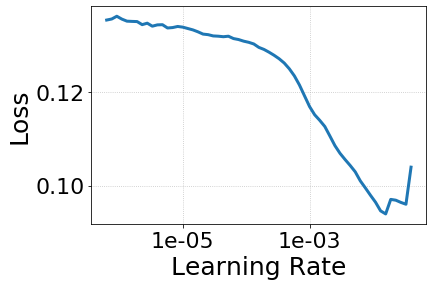

In [26]:
learn.recorder.plot()

In [28]:
lr = 1e-3
learn.fit(10, lr=lr, wd=wd)

lr = 1e-4
learn.fit(50, lr=lr, wd=wd)

lr = 1e-5
learn.fit(100, lr=lr, wd=wd)

lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

learn.save("4D_TLA_leading")

epoch,train_loss,valid_loss,time
0,0.000883,0.000843,00:52
1,0.000872,0.000844,00:52
2,0.000867,0.000845,00:52
3,0.000840,0.000848,00:53
4,0.000846,0.000830,00:51
5,0.000853,0.000845,00:52
6,0.000828,0.000835,00:51
7,0.000833,0.000813,00:52
8,0.000789,0.000793,00:51
9,0.000754,0.000751,00:52


epoch,train_loss,valid_loss,time
0,0.000726,0.000715,00:51
1,0.000710,0.000705,00:51
2,0.000708,0.000692,00:53
3,0.000680,0.000690,00:52
4,0.000678,0.000678,00:51
5,0.000699,0.000672,00:51
6,0.000687,0.000667,00:52
7,0.000662,0.000665,00:51
8,0.000666,0.000657,00:52
9,0.000651,0.000655,00:52


epoch,train_loss,valid_loss,time
0,0.000545,0.000530,00:52
1,0.000531,0.000530,00:51
2,0.000524,0.000530,00:51
3,0.000525,0.000530,00:51
4,0.000541,0.000529,00:51
5,0.000526,0.000530,00:51
6,0.000523,0.000530,00:51
7,0.000530,0.000529,00:51
8,0.000524,0.000528,00:51
9,0.000526,0.000528,00:52


epoch,train_loss,valid_loss,time
0,0.000499,0.000511,00:51
1,0.000498,0.000511,00:51
2,0.000502,0.000511,00:51
3,0.000499,0.000511,00:51
4,0.000499,0.000511,00:51
5,0.000500,0.000511,00:52
6,0.000496,0.000511,00:52
7,0.000517,0.000511,00:52
8,0.000496,0.000511,00:52
9,0.000507,0.000510,00:52


KeyboardInterrupt: 

In [29]:
learn.save("4D_TLA_leading")

In [ ]:
learn.load("4D_TLA")

In [ ]:
learn.recorder.plot_losses()
plt.yscale('log')

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')

In [ ]:
plot_activations(learn)

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
learn.recorder.plot_losses()
plt.yscale('log')

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
learn.recorder.plot_losses()
plt.yscale('log')

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(2000, lr=lr, wd=wd)

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
learn.recorder.plot_losses()
#plt.yscale('log')

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
learn.recorder.plot_losses()
plt.yscale('log')

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
learn.recorder.plot_losses()
plt.yscale('log')

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
learn.load('AE_3D_200_no1cycle_trainforever')

In [ ]:
lr = 3e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
learn.save('AE_3D_200_no1cycle_trainforever')

In [ ]:
learn.load('AE_3D_200_no1cycle_trainforever')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
plt.legend()
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
plt.legend()
#plt.yscale('log')

In [ ]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [ ]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
plt.legend()
#plt.yscale('log')

In [ ]:
#learn.save('AE_3D_200_no1cycle_trainforever')

In [ ]:
learn.load('AE_3D_200_no1cycle_trainforever')

In [ ]:
learn.validate()

In [ ]:
curr_save_folder = 'trainforever_plots/'

<Figure size 432x288 with 0 Axes>

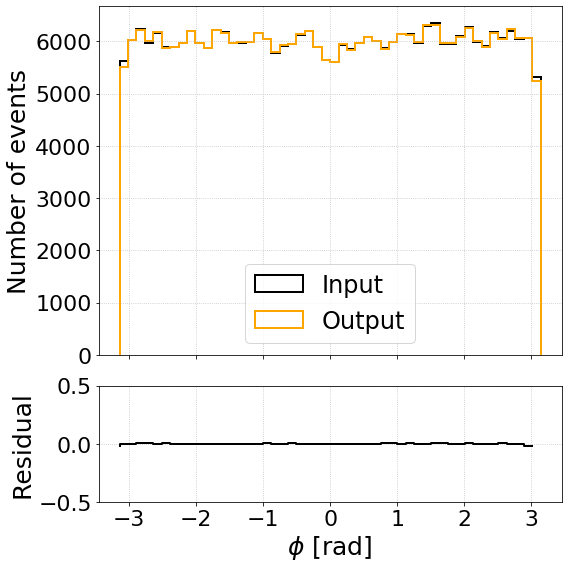

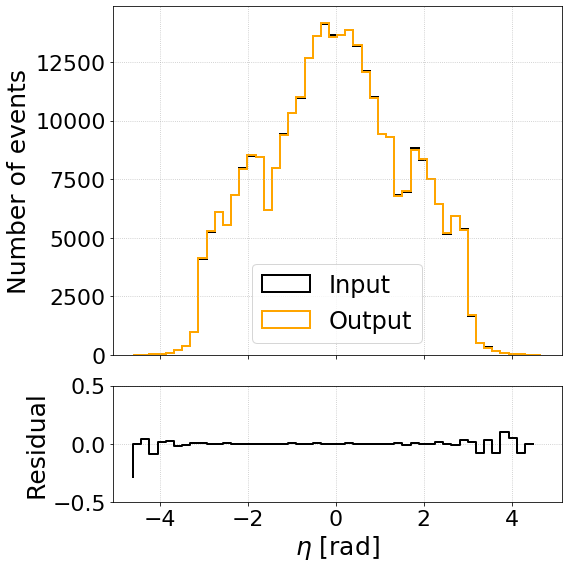

In [30]:
plt.close('all')
unit_list = ['[MeV]', '[MeV]', '[rad]', '[rad]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'black']
markers = ['*', 's']

model.to('cpu')

learn.load('4D_TLA_leading')

# Histograms
idxs = (0, 300000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
#pred = np.multiply(pred, train_std.values)
#pred = np.add(pred, train_mean.values)
#data = np.multiply(data, train_std.values)
#data = np.add(data, train_mean.values)

for d in [data,pred]:
    #data['eta'] = data['eta'] / eta_div
    d[:, 3] = d[:, 3] * eta_div
    #data['phi'] = data['phi'] / phi_div
    d[:, 2] = d[:, 2] * phi_div
    #data[:, 0] = np.pow(data['m'] + m_add) / m_div
    d[:, 0] = np.power((10,d[:, 0]) * m_div)-m_add
    #data['pt'] = (np.log10(data['pt']) - pt_sub) / pt_div
    d[:, 1] = np.power(10,d[:, 1] * pt_div)+pt_sub

def getRatio(bin1,bin2):
    # Sanity check
    if len(bin1) != len(bin2):
        print("Cannot make ratio!")
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    # The ratio can of course be expanded with eg. error
    return bins    
    
alph = 0.8
n_bins = 50
for kk in [2,3]:
    plt.figure(kk + 4)
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,8),gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    n_hist_data, bin_edges, _ = ax1.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins, histtype="step",linewidth=2)
    n_hist_pred, _, _ = ax1.hist(pred[:, kk], color=colors[0], label='Output', alpha=1, bins=bin_edges, histtype='step',linewidth=2)
    #plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    ax1.set(ylabel='Number of events')
    ms.sciy()
    # plt.yscale('log')
    ax1.legend(loc=8)
    
    rat = getRatio(n_hist_data,n_hist_pred)
    ax2.step(bin_edges[:-1],rat, color='black',linewidth=2)
    ax2.set(ylabel='Residual')
    ax2.set( ylim=(-0.5, 0.5))
    ax2.ticklabel_format(style='plain')
    plt.tight_layout()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    #plt.savefig("TLA_histogram_" + train_x.columns[kk])

In [ ]:
import utils
from scipy import stats
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
axisrange = (-.1, .1)
#range=None
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=axisrange)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

In [ ]:
residuals[:,2].shape

In [ ]:
test

In [ ]:
import corner.corner as corner
import seaborn as sns

res_df = pd.DataFrame({'m': residuals[:, 0], 'pt': residuals[:, 1], 'phi': residuals[:, 2], 'eta': residuals[:, 3]})
save = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['m', 'pt', 'phi', 'eta']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = 'corner_3d.png'
    plt.savefig('TLA_' + fig_name)